# Test of running BPZ_lite on some data with big DC2 set of 229 templats

You need to do a few steps to get things working in order to run this notebook:
1. Log into cori on the command line
2. do a `module load python` to load the conda environment
3. create a custom conda environment with `conda create -n [name for your env] python=3.9 ipykernel`
4. cd to `/global/cfs/cdirs/lsst/groups/PZ/users/sschmidt/BPZ_RAIL_TEST/DESC_BPZ`
5. run `python setup.py install --user` to install DESC_BPZ
6. (Maybe unnecessary but couldn't hurt) run the command `export PYTHONPATH=/global/cfs/cdirs/lsst/groups/PZ/users/sschmidt/BPZ_RAIL_TEST/DESC_BPZ:$PYTHONPATH` to make sure that it is grabbing this copy of DESC_BPZ (which has a few extra files that haven't been merged into the main DESC_BPZ yet)
7. cd to `/global/cfs/cdirs/lsst/groups/PZ/users/sschmidt/BPZ_RAIL_TEST/RAIL`
8. run `pip install .[base]` to install RAIL
9.  To add your new kernel as one available to be run on Jupyter Hub at NERSC, run the command `python -m ipykernel install --user --name bpzrailpy39` to create a kernel named "bpzrailpy39".  This kernel should then be available as an option when you log in to Jupyter Hub at NERSC

Stupid NERSC pathing, because I start above with the NERSC conda module, some of the software is already installed in /global/common/cori_cle7/software/python/3.9-anaconda-2021.11/lib/python3.9/site-packages, so we'll add that path below.  Also, NERSC installs some data in your .local site packages, so you'll need to add that path as well!


So, in the cell below, 

10. change the `sys.path.insert` with schmidt9/.local to the local directory where conda copies your site-packates.  It's most likely the same path but with your username in place of "schmidt9"

#### Note: this notebook is originally written by Sam Schimdt; some parts modified

In [1]:
import sys
sys.path.insert(0, "/global/cfs/cdirs/lsst/groups/PZ/users/sschmidt/BPZ_RAIL_TEST/DESC_BPZ")
sys.path.insert(0, "/global/cfs/cdirs/lsst/groups/PZ/users/sschmidt/BPZ_RAIL_TEST/RAIL")
sys.path.insert(0, "/global/cfs/cdirs/lsst/groups/PZ/users/sschmidt/BPZ_RAIL_TEST/qp")
sys.path.insert(0, "/global/cfs/cdirs/lsst/groups/PZ/users/sschmidt/BPZ_RAIL_TEST/tables_io")
########
#MODIFY THIS PATH TO POINT TO YOUR LOCAL INSTALL DIRECTORY!
#sys.path.insert(0,"/global/homes/s/schmidt9/.local/cori/3.9-anaconda-2021.11/lib/python3.9/site-packages")
sys.path.insert(0,"/global/homes/q/qhang/.local/cori/3.9-anaconda-2021.11/lib/python3.9/site-packages")
#########
sys.path.insert(0,"/global/common/cori_cle7/software/python/3.9-anaconda-2021.11/lib/python3.9/site-packages")
#let's set the path to DESC_BPZ here just to be absolutely sure, as we want to grab the specific prior file that I placed here

In [2]:
import os
import tables_io
import rail
import qp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

estimator delightPZ not installed


# Data
Start by reading in some run2.2i_dr2 data that we grabbed in the `make_run22i_dr2_test_data.ipynb`

In [4]:
inroot = '/global/cfs/cdirs/lsst/groups/PZ/users/sschmidt/BPZ_RAIL_TEST/'
inputdata = tables_io.read(inroot+"run2.2i_dr2_tract3450_testdata.pq")

In [5]:
inputdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89093 entries, 0 to 640512
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   extendedness        89093 non-null  float64
 1   blendedness         89093 non-null  float64
 2   magerr_u_cModel     84405 non-null  float64
 3   mag_z_cModel        88911 non-null  float64
 4   magerr_i_cModel     89093 non-null  float64
 5   mag_i_cModel        89093 non-null  float64
 6   mag_g_cModel        88890 non-null  float64
 7   mag_r_cModel        88988 non-null  float64
 8   magerr_g_cModel     88888 non-null  float64
 9   magerr_z_cModel     88913 non-null  float64
 10  mag_y_cModel        88974 non-null  float64
 11  ra                  89093 non-null  float64
 12  dec                 89093 non-null  float64
 13  magerr_r_cModel     88988 non-null  float64
 14  magerr_y_cModel     89045 non-null  float64
 15  mag_u_cModel        81541 non-null  float64
 16  ebv

# setting up data in the data store
start by adding a *subset* to the DataStore, once we set that up, we'll take 1/9th of the data for ~10,000 galaxies

In [6]:
smalldata = inputdata[::9]
smalldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9900 entries, 0 to 640357
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   extendedness        9900 non-null   float64
 1   blendedness         9900 non-null   float64
 2   magerr_u_cModel     9406 non-null   float64
 3   mag_z_cModel        9875 non-null   float64
 4   magerr_i_cModel     9900 non-null   float64
 5   mag_i_cModel        9900 non-null   float64
 6   mag_g_cModel        9876 non-null   float64
 7   mag_r_cModel        9892 non-null   float64
 8   magerr_g_cModel     9879 non-null   float64
 9   magerr_z_cModel     9876 non-null   float64
 10  mag_y_cModel        9885 non-null   float64
 11  ra                  9900 non-null   float64
 12  dec                 9900 non-null   float64
 13  magerr_r_cModel     9892 non-null   float64
 14  magerr_y_cModel     9891 non-null   float64
 15  mag_u_cModel        9063 non-null   float64
 16  ebv 

In [7]:
xtest_data = tables_io.convert(smalldata, tables_io.types.NUMPY_DICT)

In [9]:
xtest_data

OrderedDict([('extendedness', array([1., 1., 1., ..., 1., 1., 1.])),
             ('blendedness',
              array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     4.80962123e-05, 2.90147235e-04, 7.11368463e-07])),
             ('magerr_u_cModel',
              array([ 0.47875334,  1.38144173,  0.16529846, ..., -0.85881331,
                      0.3656084 ,  0.02407504])),
             ('mag_z_cModel',
              array([23.42043298, 22.22403922, 22.31729021, ..., 20.22364572,
                     22.65296762, 19.35838622])),
             ('magerr_i_cModel',
              array([0.04055852, 0.02226778, 0.02474736, ..., 0.00628354, 0.03066676,
                     0.00297524])),
             ('mag_i_cModel',
              array([23.47946153, 22.50099473, 22.53255588, ..., 20.61947629,
                     23.17186784, 19.64490474])),
             ('mag_g_cModel',
              array([24.69731805, 23.87903338, 24.04089038, ..., 23.11319867,
                

In [39]:
#import RailStage stuff
from rail.core.data import TableHandle
from rail.core.stage import RailStage
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

In [10]:
test_data = DS.add_data("test_data", xtest_data, TableHandle )

In [11]:
DS

DataStore
{  test_data:<class 'rail.core.data.TableHandle'> None, (d)
}

In [12]:
xx=test_data.data['mag_u_cModel_dered']

In [13]:
print(xx)

[25.459214   26.33323614 23.94854229 ...         nan 25.13962779
 21.36766319]


# stage BPZ
set up the stage for the BPZ run

In [45]:
from rail.estimation.algos.bpz_lite import BPZ_lite

In [16]:
#mag limits for Y2 data will actually be shallower!  Should update those numbers rather than just copying the Y10 numbers!
estimate_bpz = BPZ_lite.make_stage(name='estimate_bpz', hdf5_groupname='', columns_file=inroot+'bpz_run22i_dered.columns',
                                   nondetect_val=np.nan, spectra_file='SED/dc2_templates_v4.list',
                                  band_names=['mag_u_cModel_dered','mag_g_cModel_dered','mag_r_cModel_dered','mag_i_cModel_dered','mag_z_cModel_dered','mag_y_cModel_dered'],
                                  band_err_names=['magerr_u_cModel','magerr_g_cModel','magerr_r_cModel',
                                                  'magerr_i_cModel','magerr_z_cModel','magerr_y_cModel'],
                                  prior_band='mag_i_cModel_dered',
                                  mag_limits = dict(mag_u_cModel_dered=27.79,
                                                    mag_g_cModel_dered=29.04,
                                                    mag_r_cModel_dered=29.06,
                                                    mag_i_cModel_dered=28.62,
                                                    mag_z_cModel_dered=27.98,
                                                    mag_y_cModel_dered=27.05),
                                  output="test_BPZ_run2.2i_dr2_qpens.hdf5")

In [17]:
%%time
bpz_estimated = estimate_bpz.estimate(test_data)

Inserting handle into data store.  output_estimate_bpz: inprogress_test_BPZ_run2.2i_dr2_qpens.hdf5, estimate_bpz
CPU times: user 2min 55s, sys: 126 ms, total: 2min 55s
Wall time: 2min 55s


In [18]:
bpz_estimated

In [19]:
zmods = bpz_estimated.data.ancil['zmode']

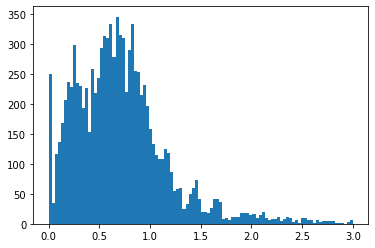

In [20]:
plt.hist(zmods,bins=np.linspace(0,3,101));

# Test reading back in of BPZ data to make sure that it worked correctly!

In [21]:
newens = qp.read(inroot + "test_BPZ_run2.2i_dr2_qpens.hdf5")

In [22]:
means = newens.mean()

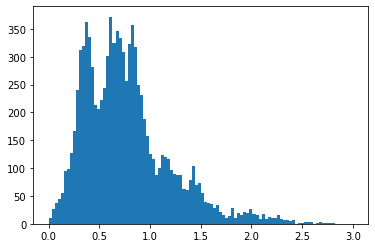

In [23]:
plt.hist(means, bins=np.linspace(0,3,101));

## DC2 dr2 objects here:

In [27]:
from astropy.io import fits

In [28]:
#open with tables_io
fname='/global/cscratch1/sd/qhang/DESC_DC2_obs-dr2/DC2_obj-sub-0.05-all-tracts-dered.fits'

#inputdata = tables_io.read(fname)
fin = fits.open(fname)

In [29]:
from collections import OrderedDict

In [33]:
keys = fin[1].columns.names

In [35]:
data = OrderedDict()

for key in keys:
    data[key] = fin[1].data[key]


In [38]:
#number of objects with imag<24.1?

print(len(fin[1].data['mag_i_cModel_dered']))
ind = fin[1].data['mag_i_cModel_dered']<24.1
print(len(fin[1].data['mag_i_cModel_dered'][ind]))

2217361
1156413


In [36]:
data

OrderedDict([('tract', array([2724, 2726, 2896, ..., 5074, 5074, 5074])),
             ('ra',
              array([52.8255827 , 55.20033071, 49.80342739, ..., 70.61417247,
                     70.65977073, 70.67849323])),
             ('dec',
              array([-44.6282278 , -44.6305967 , -44.62457398, ..., -26.99114607,
                     -26.98669494, -26.97483743])),
             ('redshift_truth',
              array([0.34757888, 0.55571771, 0.65298444, ..., 0.67561525, 0.        ,
                     0.        ])),
             ('mag_u_cModel_dered',
              array([        nan,         nan,         nan, ..., 24.2182114 ,
                     23.92880274,         nan])),
             ('mag_g_cModel_dered',
              array([        nan,         nan,         nan, ..., 23.83676622,
                             nan,         nan])),
             ('mag_r_cModel_dered',
              array([        nan,         nan,         nan, ...,         nan,
                     23.466

In [42]:
DC2_data = DS.add_data("DC2_data", data, TableHandle)

In [43]:
xx=DC2_data.data['mag_u_cModel_dered']
xx

array([        nan,         nan,         nan, ..., 24.2182114 ,
       23.92880274,         nan])

In [46]:
#mag limits for Y2 data will actually be shallower!  Should update those numbers rather than just copying the Y10 numbers!
estimate_bpz = BPZ_lite.make_stage(name='estimate_bpz', hdf5_groupname='', columns_file=inroot+'bpz_run22i_dered.columns',
                                   nondetect_val=np.nan, spectra_file='SED/dc2_templates_v4.list',
                                  band_names=['mag_u_cModel_dered','mag_g_cModel_dered','mag_r_cModel_dered',
                                              'mag_i_cModel_dered','mag_z_cModel_dered','mag_y_cModel_dered'],
                                  band_err_names=['magerr_u_cModel','magerr_g_cModel','magerr_r_cModel',
                                                  'magerr_i_cModel','magerr_z_cModel','magerr_y_cModel'],
                                  prior_band='mag_i_cModel_dered',
                                  mag_limits = dict(mag_u_cModel_dered=27.79,
                                                    mag_g_cModel_dered=29.04,
                                                    mag_r_cModel_dered=29.06,
                                                    mag_i_cModel_dered=24.10, #changed the i-band limit
                                                    mag_z_cModel_dered=27.98,
                                                    mag_y_cModel_dered=27.05),
                                  output="DC2_BPZ_run2.2i_dr2_qpens.hdf5")

In [ ]:
bpz_estimated = estimate_bpz.estimate(DC2_data)

In [ ]:
bpz_estimated

In [ ]:
zmods = bpz_estimated.data.ancil['zmode']
plt.hist(zmods,bins=np.linspace(0,3,101))